In [1]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import numpy.linalg as la
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
import pandas as pd
from data_parser import parse
from data_modification import normalise_patient, center_patient, cylindrical_patient
from visualization.plot_vcg import plot_vcg_axes, plot_3d_vcg

%load_ext autoreload
%autoreload 2

In [2]:
patient_no = 1
data_path = 'C:/Users/yngve_000/Dropbox/SimulaSummerSchool_Group9/data/lbbb_lvdyssync'

In [3]:
patient = normalise_patient(parse(initial_path=data_path, patient_number=patient_no))
patient_center = center_patient(patient)
patient_cyl = cylindrical_patient(patient_center)

# 3D plots of heart vectors

<IPython.core.display.Javascript object>


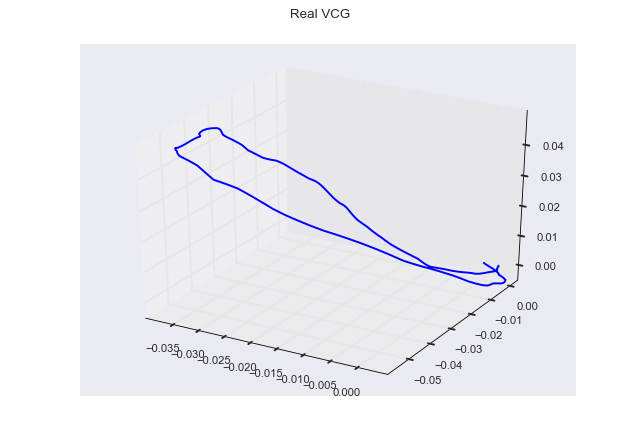

In [4]:
fig, _, _ = plot_3d_vcg(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>


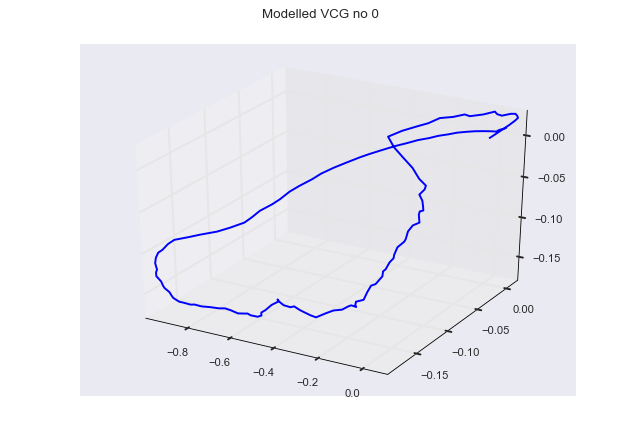

In [5]:
fig, ax, wire = plot_3d_vcg(np.array(patient['vcg_model'][0]))
fig.suptitle('Modelled VCG no 0')

pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, wire, pat_slider
    fig, ax, wire = plot_3d_vcg(np.array(patient['vcg_model'][pat_slider.value]), figure=fig, axes=ax, wire=wire)
    fig.suptitle('Modelled VCG no{}'.format(pat_slider.value))
    
plot_button.on_click(replot)

display(pat_slider, plot_button)

# VCG's in cartesian coordinates

<IPython.core.display.Javascript object>


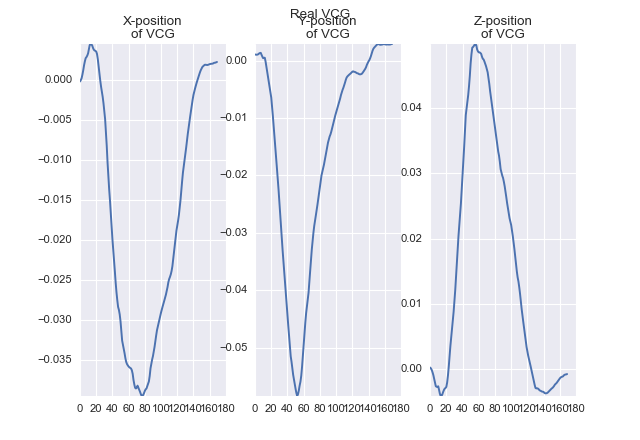

In [6]:
fig, _, _, = plot_vcg_axes(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>


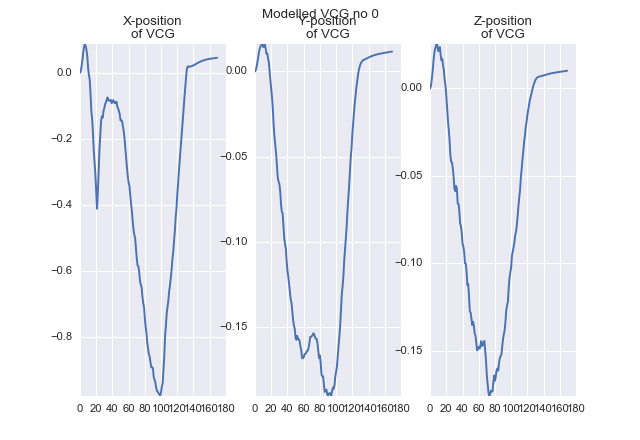

In [7]:
fig, ax, plots = plot_vcg_axes(np.array(patient['vcg_model'][0]))
fig.suptitle('Modelled VCG no 0')
pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, plots, pat_slider
    plot_vcg_axes(np.array(patient['vcg_model'][pat_slider.value]), figure=fig, axes=ax, plots=plots)
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button.on_click(replot)
display(pat_slider, plot_button)

# VCGs in cylindrical coordinates
### After centering

<IPython.core.display.Javascript object>


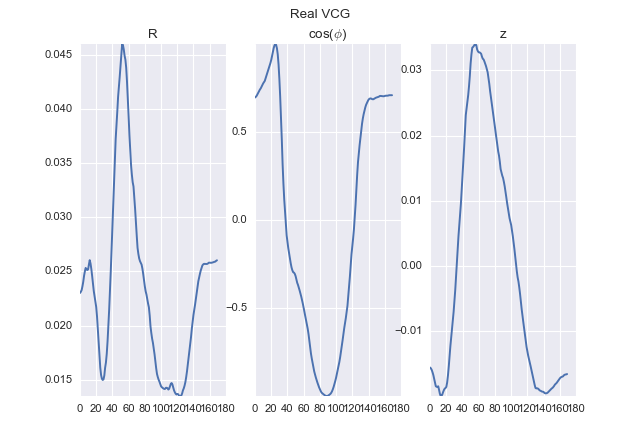

In [8]:
transforms = [None, lambda x: np.cos(x), None]
fig, _, _, = plot_vcg_axes(np.array(patient_cyl['vcg_real']), titles=['R', 'cos($\phi$)', 'z'], transforms=transforms)
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>


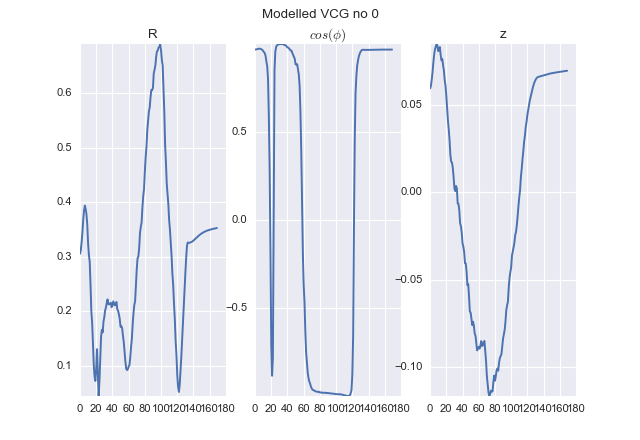

In [9]:
transforms = [None, lambda x: np.cos(x), None]
fig, ax, plots = plot_vcg_axes(np.array(patient_cyl['vcg_model'][0]), titles=['R', '$cos(\phi)$', 'z'], transforms=transforms)
fig.suptitle('Modelled VCG no 0')
pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, plots, pat_slider
    plot_vcg_axes(np.array(patient_cyl['vcg_model'][pat_slider.value]), figure=fig, axes=ax, plots=plots, titles=['R', 'cos($\phi$)', 'z'], transforms=transforms)
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button.on_click(replot)
display(pat_slider, plot_button)

# Exploration of basic features vs dyssynchrony

## 2D plots - not much information here

In [10]:
# General properties for plotting
transforms = [None, lambda x: np.cos(x), None]
dyssyncs = patient_cyl['desync'].values
cmap = plt.cm.get_cmap('viridis')
colour_range = colors.Normalize(vmin=dyssyncs[dyssyncs != 0].min(), vmax=dyssyncs.max())
normalised_map = cmx.ScalarMappable(norm=colour_range, cmap=cmap)

<IPython.core.display.Javascript object>


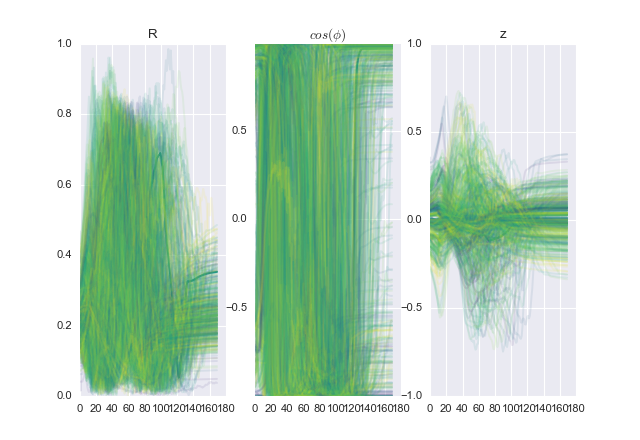

(-1, 1)

In [54]:
fig, axes, plots = fig, ax, plots = plot_vcg_axes(
    vcg = np.array(patient_cyl['vcg_model'][0]), 
    color = normalised_map.to_rgba(dyssyncs[0]),
    titles = ['R', '$cos(\phi)$', 'z'], 
    transforms = transforms
)

for dyssync, simulation in zip(dyssyncs, patient_cyl['vcg_model']):
    simulation = np.array(simulation)
    min_z = np.min(simulation[:, 2]) if np.min(simulation[:, 2]) < min_z else min_z
    max_z = np.max(simulation[:, 2]) if np.max(simulation[:, 2]) > max_z else max_z
    color = np.array(normalised_map.to_rgba(dyssync))
    color[3] = 0.1
    fig, axes, _ = plot_vcg_axes(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        titles = ['R', '$cos(\phi)$', 'z'],
        transforms = transforms,
        set_lims=False
    )

axes[0].set_ylim(0, 1)
axes[2].set_ylim(-1, 1)

## 3D plots - not much info here

<IPython.core.display.Javascript object>


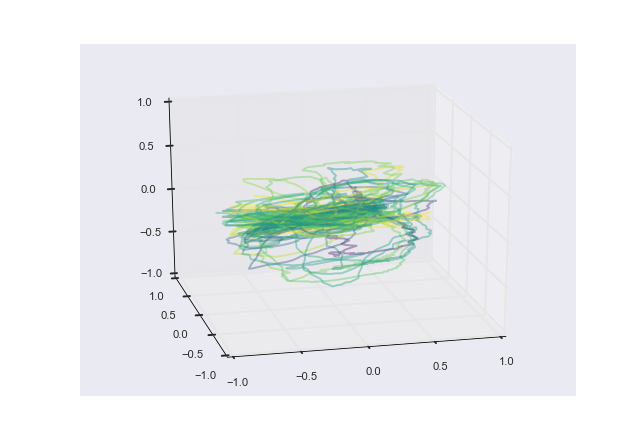

(-1, 1)

In [66]:
np.array(normalised_map.to_rgba(dyssyncs[0]))
color[3] = 0.4
fig, axes, _ = plot_3d_vcg(np.array(patient_center['vcg_model'][0]), color=color, set_lims=False)

i = 0
for dyssync, simulation in zip(dyssyncs, patient_center['vcg_model']):
    i += 1
    if i % 10 != 0:
        continue
    simulation = np.array(simulation)
    color = np.array(normalised_map.to_rgba(dyssync))
    color[3] = 0.4
    fig, axes, _ = plot_3d_vcg(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        set_lims=False
    )

axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
axes.set_zlim(-1, 1)

# PCA scatter plot

### Compute PCA

In [11]:
data_matrix = np.zeros((len(patient_center['vcg_model']), np.prod(patient_center['vcg_model'][0].shape)))
for i, simulation in enumerate(patient_center['vcg_model']):
    data_matrix[i] = simulation.values.reshape(np.prod(simulation.shape))

In [12]:
# Get offset vector:
mean_vals = data_matrix.mean(axis=0, keepdims=True)

# Center data matrix:
dm_center = data_matrix - mean_vals

# Compute principal components:
U, S, V = np.linalg.svd(dm_center)

<IPython.core.display.Javascript object>


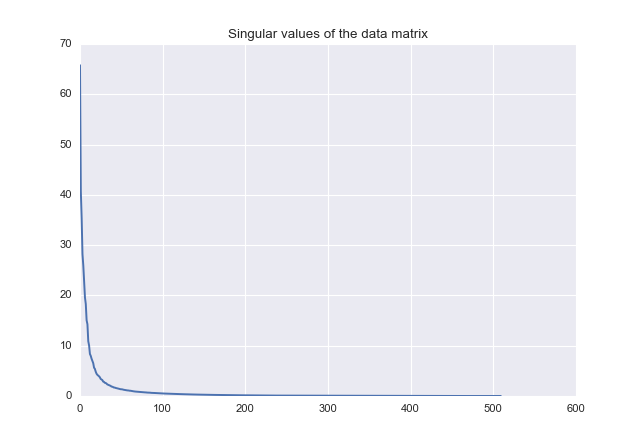

In [13]:
plt.figure()
plt.plot(S)
plt.title('Singular values of the data matrix')

## Perform coordinate change to principal axes

<IPython.core.display.Javascript object>


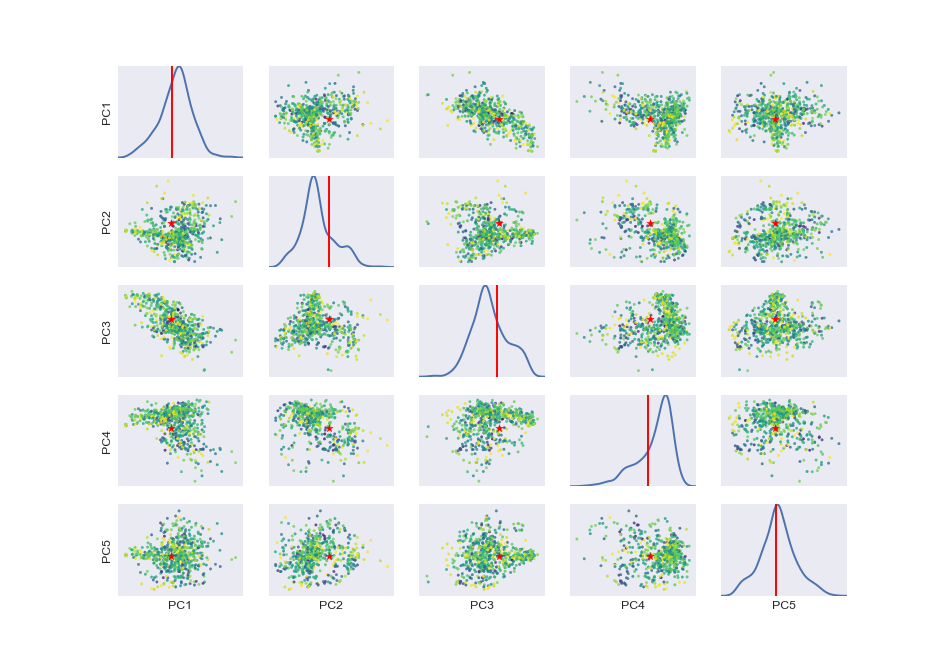

In [44]:
pca_matrix = dm_center.dot(V)
pca_matrix_clean = pca_matrix[dyssyncs != 0, :]
dyssyncs_clean = dyssyncs[dyssyncs != 0]
patient_vector = np.reshape(patient_center['vcg_real'].values, [np.prod(patient_center['vcg_real'].values.shape)])
pca_real = (patient_vector - mean_vals).dot(V)[0]

colors = normalised_map.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix_clean, dyssyncs_clean.reshape([dyssyncs_clean.shape[0], 1])], axis=1), 
    columns = column_titles
)

fig = plt.figure()
axes = []
num_components = 5
for i in range(num_components):
    for j in range(num_components):
        axes.append(fig.add_subplot(num_components, num_components, i*num_components + j + 1))
        axes[i*num_components+j].set_xticks([])
        axes[i*num_components+j].set_yticks([])
        if i == j:
            sns.kdeplot(pca_df[column_titles[i]], legend=False)
            ymin, ymax = axes[i*num_components+j].get_ylim()
            axes[i*num_components+j].plot([pca_real[i], pca_real[i]], [ymin, ymax], 'r')
        else:
            axes[i*num_components+j].scatter(pca_df[column_titles[j]], pca_df[column_titles[i]], color=colors, s=5, alpha=0.8)
            axes[i*num_components+j].scatter(pca_real[j], pca_real[i], color='r', marker='*', s=50)
    

for i in range(num_components):
    axes[i*num_components].set_ylabel(column_titles[i])
    axes[i+num_components*(num_components-1)].set_xlabel(column_titles[i])

In [37]:
pca_real[1]

IndexError: index 1 is out of bounds for axis 0 with size 1